<a href="https://colab.research.google.com/github/miadibe/CASA0004/blob/master/03_FloorSegmentation_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FLOOR DETECTOR - SITE IMAGE SEGMENTATION**

In [ ]:
#Inspired by https://github.com/daveluo/zanzibar-aerial-mapping/blob/master/archive/znz-segment-buildingfootprint-20181119.ipynb
# And Fastai https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
import fastai
print(fastai.__version__)

1.0.61


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
# If run out of memory, run this
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Load Data
u = 'username';
p = 'password'; 
!git clone https://$u:$p@github.com/$u/AEC-Demo.git


Cloning into 'AEC-Demo'...
remote: Enumerating objects: 6697, done.
remote: Total 6697 (delta 0), reused 0 (delta 0), pack-reused 6697
Receiving objects: 100% (6697/6697), 13.75 GiB | 4.78 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Checking out files: 100% (8644/8644), done.


In [ ]:
#CAMVID NOTEBOOK
'''
src = (SegmentationItemList.from_folder(path).split_by_folder(valid='val').label_from_func(get_y_fn, classes=codes))

bs=4
data = (src.transform(get_transforms(), tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

fnames = get_image_files(path_img)
fnames[:3]

lbl_names = get_image_files(path_lbl)
lbl_names[:3]

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

size = src_size
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-2)      
'''

In [ ]:
path = Path('/content/AEC-Demo/segmentation')
path.ls()

[PosixPath('/content/AEC-Demo/segmentation/.DS_Store'),
 PosixPath('/content/AEC-Demo/segmentation/images-512'),
 PosixPath('/content/AEC-Demo/segmentation/masks-512'),
 PosixPath('/content/AEC-Demo/segmentation/data_annotated')]

In [ ]:
path_lbl = path/'masks-512'
path_img = path/'images-512'

In [ ]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3]

([PosixPath('/content/AEC-Demo/segmentation/images-512/2004101500004322_10-floors_img.jpg'),
  PosixPath('/content/AEC-Demo/segmentation/images-512/2004101600004326_10-floors_img.jpg'),
  PosixPath('/content/AEC-Demo/segmentation/images-512/2006251400008908_12-floors_img.jpg')],
 [PosixPath('/content/AEC-Demo/segmentation/masks-512/2006100730007963_11-floors_mask.png'),
  PosixPath('/content/AEC-Demo/segmentation/masks-512/2007080715009700_13-floors_mask.png'),
  PosixPath('/content/AEC-Demo/segmentation/masks-512/1812260730005363_0-floor_mask.png')])

In [ ]:
len(fnames), len(lbl_names)

(1600, 1600)

In [ ]:
## Side code to open PNG from Labelme

import numpy as np
import PIL.Image

label_png = lbl_names[0]
lbl = np.asarray(PIL.Image.open(label_png))
print(lbl.dtype)
np.unique(lbl)
#lbl.shape



uint8


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem.split("_img")[0]}_mask.png'

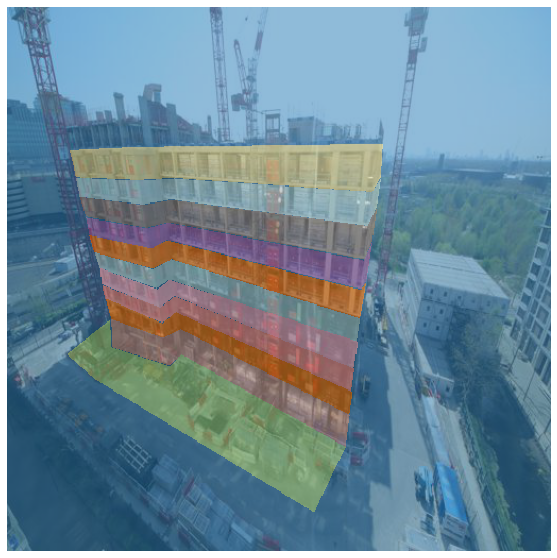

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

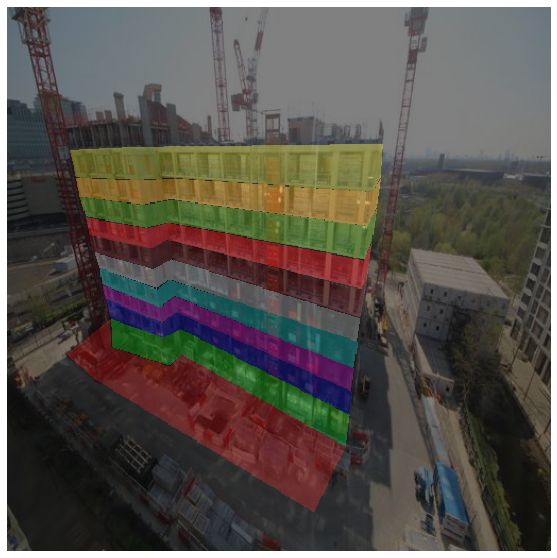

In [ ]:
# test that masks are opening correctly with open_mask() settings

img_f = fnames[0]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

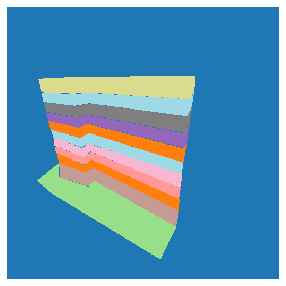

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[512 512]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
mask.shape

torch.Size([1, 512, 512])

In [ ]:
(mask.data != 0).sum(dim=1)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   2,   4,   8,  13,  19,  24,  31,  38,  43,  50,  56,  65,  71,
          74,  79,  85,  90,  94, 100, 108, 116, 122, 126, 131, 135, 138, 144,
         148, 152, 156, 162, 172, 180, 186, 191, 197, 202, 207, 212, 218, 210,
         206, 224, 225, 228, 225, 228, 228, 226, 228, 228, 232, 233, 232, 232,
         232, 234, 233, 235, 236, 235, 239, 239, 239, 239, 237, 240, 242, 243,
         244, 242, 244, 244, 242, 245, 246, 244, 245, 247, 245, 248, 248, 248,
         251, 248, 252, 251, 251, 251, 252, 253, 252, 255, 256, 256, 257, 258,
         257, 256, 258, 262, 260, 263, 263, 261, 265, 264, 266, 268, 267, 268,
         270, 270, 269, 268, 272, 271, 273, 273, 273

In [ ]:
size = src_size
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [ ]:
# Make DataBunch
size = src_size
bs= 4

#started with batch size = 16. too slow. then batch size = 2

In [ ]:
mask_opener=partial(open_mask, div=True)

In [ ]:
print(size)

[512 512]


In [ ]:
holdout_grids = ['18101','19031','20011','20072']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [ ]:
# the classes corresponding to each channel
codes = np.array(['_background_','floor0','floor1', 'floor10', 'floor11','floor12', 'floor13',
                  'floor14','floor15','floor2','floor3','floor4','floor5',
                  'floor6','floor7','floor8','floor9'])

In [ ]:
# overriding to set open_mask(fn, div=True), probably a better way to do this
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/19

class SegmentationLabelList(ImageList):
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)
        self.c = len(self.classes)

    def new(self, items, classes=None, **kwargs):
        return self.__class__(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(ImageList): _label_cls = SegmentationLabelList

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=['0','1','2','3','4','5','6','7',
                                            '8','9','10','11','12','13','14','15','16']))

In [ ]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (1465 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/AEC-Demo/segmentation/images-512;

Valid: LabelList (135 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/AEC-Demo/segmentation/images-512;

Test: None

In [ ]:
data.train_ds[0][1].data.max()

tensor(132)

In [ ]:
mask.data.data.max()

tensor(132)

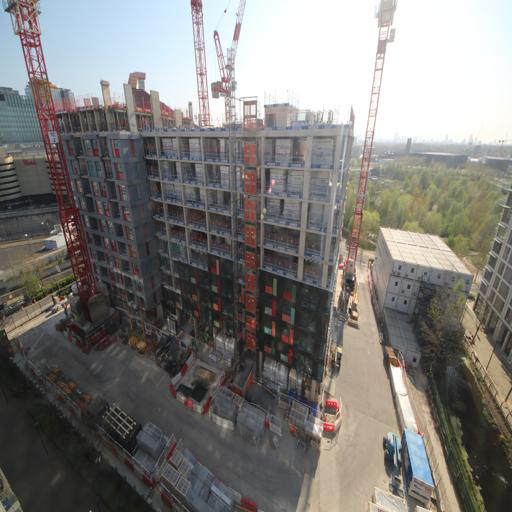

In [ ]:
data.train_ds.x[1]

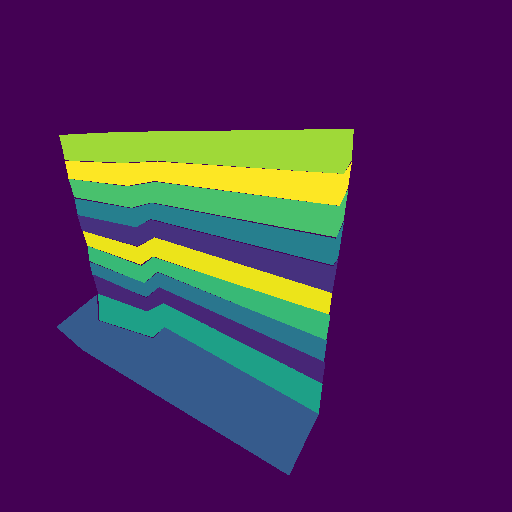

In [ ]:
data.train_ds.y[1]

In [ ]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
(data.train_ds.y[1].data != 0).sum(dim=1)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [ ]:
data.show_batch(2,figsize=(12,12))

RuntimeError: ignored

In [ ]:
data.show_batch(2,figsize=(12,12), ds_type=DatasetType.Valid)

RuntimeError: ignored

In [ ]:
# TRAIN MODEL RESTNET34
iou = partial(dice, iou=True)
metrics = [iou, dice]

In [ ]:
wd = 1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=CrossEntropyFlat(axis=1, 
                    weight=torch.tensor([.4,.1,.1,.1,2.5,.1]).cuda()), wd=wd)

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, ignore_index=255,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#weights = torch.ones(data.c).float().cuda()
learn = unet_learner(data, models.resnet34, metrics=metrics, 
        loss_func=CrossEntropyFlat(axis=1, 
                    weight=torch.tensor([.4,.1,.1,.1,2.5,.1]).cuda()),
        wd=wd)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1300 MB |   10776 MB |   77101 MB |   75801 MB |\n|       from large pool |    1248 MB |   10735 MB |   76970 MB |   75721 MB |\n|       from small pool |      51 MB |      75 MB |     131 MB |      79 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1300 MB |   10776 MB |   77101 MB |   75801 MB |\n|       from large pool |    1248 MB |   10735 MB |

In [ ]:
import gc 
# Your code with pytorch using GPU
gc.collect() 

2837

In [ ]:
learn.loss_func = CrossEntropyFlat(axis=1)

In [ ]:
learn.lr_find()
learn.recorder.plot()

#ValueError: Expected input batch_size (4096) to match target batch_size (65536)
# OR RuntimeError: CUDA out of memory. Tried to allocate 754.00 MiB (GPU 0; 2.00 GiB total capacity; 1.21 GiB already allocated …)

epoch,train_loss,valid_loss,dice,dice,time


RuntimeError: ignored

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(10, max_lr=lr)

In [ ]:
learn.save('20200731-rn34unet-fseg-stage1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr/5))

In [ ]:
learn.save('20200731-rn34unet-fseg-stage2')

In [ ]:
learn.load('20200731-rn34unet-fseg-stage2')

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
def accuracy_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.view(n,2,-1).argmax(dim=1)
    return (input==targs).float().mean()

In [ ]:
learn.metrics = [accuracy_fixed, iou, dice]

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

In [ ]:
learn.save('20200731-rn34unet-fseg-stage2_2')

In [ ]:
learn.model.train()

In [ ]:
learn.save('20200731-rn34unet-fseg-stage2_3')

In [ ]:
# See Predictions 
learn.load('20200731-rn34unet-fseg-stage2_3')
learn.model.eval()

In [ ]:
outputs = learn.pred_batch()

In [ ]:
outputs.shape

In [ ]:
plt.imshow((to_np(outputs[0][1])))

In [ ]:
for i in range(20):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1])), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
## https://forums.fast.ai/t/image-segmentation-understanding-inference/45855/9


cmap='tab20'
fig,axes=plt.subplots(1,2,figsize=(sz,sz))

#image
im=axes[0].imshow(image2np(t),cmap=cmap)

#labels
c = len(classes)
n = math.ceil(np.sqrt(c))
axes[1].imshow(np.array(range(c)).reshape(n,n), cmap='tab20')
for i,l in enumerate(classes):
    div,mod=divmod(i,n)
    axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})
axes[1].set_yticks([]);axes[1].set_xticks([]);

In [ ]:
# Or
def interp_show(ims:ImageSegment, classes:Collection, sz:int=20, cmap='tab20', c2i:dict=c2i):
    'show ImageSegment with given the classes'
    fig,axes=plt.subplots(1,2,figsize=(sz,sz))

    #image
    mask = (torch.cat([ims.data==i for i in [c2i[c] for c in classes]])
            .max(dim=0)[0][None,:]).long()
    masked_im = image2np(ims.data*mask)
    im=axes[0].imshow(masked_im, cmap=cmap)
    
    #labels
    labels = list(np.unique(masked_im))
    c = len(labels); n = math.ceil(np.sqrt(c))
    label_im = labels + [np.nan]*(n**2-c)
    label_im = np.array(label_im).reshape(n,n)
    axes[1].imshow(label_im, cmap=cmap)
    
    i2c = {i:c for c,i in c2i.items()}


    #Note: Tricky part is to have unique values same in both mask image and label image otherwise cmap will give different values. Also cmap squishes values to be mappable so if len(classes) > 20 then classes with close idxs, say 4 and 5, will be mapped to the same color.

In [ ]:
interp_show(ImageSegment(t), classes[:10], sz=10)
interp_show(ImageSegment(interp.y_true[457]), classes[:10], sz=10)

In [ ]:
# Also another note is that max number of classes is 20 in qualitative colormaps of matplotlib. So, if you have 21 classes 2 classes will be mapped to the same color.

In [ ]:
## https://github.com/KeremTurgutlu/experimental/blob/master/interpret-segmentation.ipynb

In [ ]:
import sys; sys.path.insert(0,"/home/ubuntu/fastai-fork/")
from fastai.vision.interpret import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.script import *
from fastai.utils.mem import *
from deepcut import *
import datasets
from utils import *

In [ ]:
# data

path, data_name = "../data/mhp/", "MHPData"
sample_size, bs, size = None, 8, (320, 320)
path = Path(path)
DatasetClass = getattr(datasets, data_name)
dataobj = DatasetClass(path=path, sample_size=sample_size, bs=bs, size=size)

In [ ]:
test_data = dataobj.get_testdata()

In [ ]:
test_data

In [ ]:
# Load Model

use_deepcut=0
if not use_deepcut:
    learn = unet_learner(test_data, models.resnet34, model_dir='../../../custom_segmentation', 
                         pretrained=False, self_attention=False)
else:
    m =  deepcut()
    learn = Learner(test_data, m, model_dir='../../../custom_segmentation')

In [ ]:
learn.load('./best_dunet_mhp_coco++_finetune_inet_full');

In [ ]:

learn.metrics = [partial(foreground_acc, void_code=0),
                 partial(multilabel_dice, classes=range(learn.data.y.c)),
                 partial(multilabel_iou, classes=range(learn.data.y.c))]

In [ ]:
# learn.validate(learn.data.valid_dl)
# learn.data.train_ds.y.classes
# fig = learn.show_results(rows=10, alpha=0.8)

In [ ]:
# Interpret
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((320,320))

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

In [ ]:
# single image class dice, iou

# from utils import *

# interp.preds.shape, interp.y_true.shape

# classes = interp.data.classes

# dice_scores = multilabel_dice(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)

# dice_scores = multilabel_dice(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)
# dict(zip(classes, dice_scores))

# iou_scores = multilabel_iou(interp.preds[0][None,:], interp.y_true[0][None,:], range(interp.data.c), reduce=None)
# dict(zip(classes, iou_scores))

# interp.data.classes

# interp.show_xyz(0)

In [ ]:
# Confusion Matrix
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# bring it all together

# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

In [ ]:
############# For labeling: LABELME MIT PROJECT
# CITE
@misc{labelme2016,
  author =       {Kentaro Wada},
  title =        {{labelme: Image Polygonal Annotation with Python}},
  howpublished = {\url{https://github.com/wkentaro/labelme}},
  year =         {2016}
}